In [11]:
import yfinance as yf
from datetime import datetime
import numpy as np
from scipy.stats import kurtosis, skew, norm, t
import pandas as pd

import cufflinks as cf
cf.set_config_file(offline=True)

import warnings
warnings.filterwarnings('ignore')


from scipy import stats
import matplotlib.pyplot as plt

a) Descarga de datos de un activo financiero desde 2010

In [2]:
# Obtener la fecha de hoy en formato YYYY-MM-DD
hoy = datetime.today().strftime('%Y-%m-%d')

df = yf.download('^DJI', start='2010-01-01', end=hoy, progress=False)
df

YF.download() has changed argument auto_adjust default to True


Price,Close,High,Low,Open,Volume
Ticker,^DJI,^DJI,^DJI,^DJI,^DJI
Date,,,,,
2010-01-04,10583.959961,10604.969727,10430.690430,10430.690430,179780000
2010-01-05,10572.019531,10584.559570,10522.519531,10584.559570,188540000
2010-01-06,10573.679688,10594.990234,10546.549805,10564.719727,186040000
2010-01-07,10606.860352,10612.370117,10505.209961,10571.110352,217390000
2010-01-08,10618.190430,10619.400391,10554.330078,10606.400391,172710000
...,...,...,...,...,...
2025-03-27,42299.699219,42523.839844,42142.191406,42432.960938,484540000
2025-03-28,41583.898438,42258.148438,41530.000000,42245.820312,532360000


b) Rendimientos diarios

In [ ]:
rendimiento_simple = df["Close"].pct_change().dropna()
#rendimiento_simple

media = np.mean(rendimiento_simple)
sesgo = skew(rendimiento_simple)
desviacion = np.std(rendimiento_simple)
exceso_curtosis = kurtosis(rendimiento_simple) - 3

estadisticas_simple = pd.DataFrame({'Media': [media],"Desviación":[desviacion] ,'Sesgo': [sesgo], 'Exceso de curtosis': [exceso_curtosis]},index=['Estadísticas'])

# Mostrar resultados
print(estadisticas_simple)

Ticker          ^DJI
Date                
2010-01-05 -0.001128
2010-01-06  0.000157
2010-01-07  0.003138
2010-01-08  0.001068
2010-01-11  0.004313
...              ...
2025-03-27 -0.003653
2025-03-28 -0.016922
2025-03-31  0.010049
2025-04-01 -0.000281
2025-04-02  0.005605

[3835 rows x 1 columns]
                 Media                             Desviación  \
Estadísticas  0.000416  Ticker
^DJI    0.01043
dtype: float64   

                              Sesgo    Exceso de curtosis  
Estadísticas  [-0.5139922988193419]  [15.260849733285585]  


In [32]:
layout = dict(title="Retornos", font=dict(family="Arial", size=12, color="black"))

df.iplot(kind='line',layout=layout)

In [5]:
rendimiento_log = np.log(df["Close"]).diff().dropna()
#rendimiento_log

media_log = np.mean(rendimiento_log)
sesgo_log = skew(rendimiento_log)
desviacion_log = np.std(rendimiento_log)
exceso_curtosis_log = kurtosis(rendimiento_log) - 3

estadisticas_simple = pd.DataFrame({'Media': [media_log], 'Sesgo': [sesgo_log], "Desviación":[desviacion_log],'Exceso de curtosis': [exceso_curtosis_log]},index=['Estadísticas'])

# Mos<trar resultados
print(estadisticas_simple)

                 Media                  Sesgo  \
Estadísticas  0.000361  [-0.8354620702338273]   

                                          Desviación   Exceso de curtosis  
Estadísticas  Ticker
^DJI    0.010465
dtype: float64  [16.62479687091101]  


/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:3800: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


c) Calcula el VaR y ES para la serie completa de datos a los siguientes intervalos de confianza:

α = 0,95, 0,975, y 0,99

bajo una aproximacion paramétrica asumiendo una distribución normal y t-
student, además bajo una aproximación histórica y Monte Carlo. Muestra tus resultados en una tabla en el reporte.

In [6]:

VaR_normal, ES_normal = [], []
VaR_t, ES_t = [], []
hVaR, hES = [], []
VaR_m, ES_m = [], []

for alfa in [0.95, 0.975, 0.99]:
    # Normal
    var = norm.ppf(1 - alfa, media, desviacion)
    es = rendimiento_simple[rendimiento_simple <= var].mean()
    if isinstance(es, (pd.Series, np.ndarray)):
        es = es.values[0]
    VaR_normal.append(var)
    ES_normal.append(es)

    # T-Student
    var = t.ppf(1 - alfa, len(rendimiento_simple) - 1) * desviacion + media
    if isinstance(var, (pd.Series, np.ndarray)):
        var = var.values[0]
    es = rendimiento_simple[rendimiento_simple <= var].mean()
    if isinstance(es, (pd.Series, np.ndarray)):
        es = es.values[0]
    VaR_t.append(var)
    ES_t.append(es)

    # Histórico
    var = rendimiento_simple.quantile(1 - alfa)
    if isinstance(var, (pd.Series, np.ndarray)):
        var = var.values[0]
    es = rendimiento_simple[rendimiento_simple <= var].mean()
    if isinstance(es, (pd.Series, np.ndarray)):
        es = es.values[0]
    hVaR.append(var)
    hES.append(es)

    # MonteCarlo
    n = 100000
    simulaciones = np.random.normal(media, desviacion, n)
    var = np.percentile(simulaciones, (1 - alfa) * 100)
    es = rendimiento_simple[rendimiento_simple <= var].mean()
    if isinstance(es, (pd.Series, np.ndarray)):
        es = es.values[0]
    VaR_m.append(var)
    ES_m.append(es)

# Crear DataFrame con los resultados
resultados = pd.DataFrame({
    "Nivel de Confianza": [0.95, 0.975, 0.99],
    "VaR_Normal": VaR_normal,
    "ES_Normal": ES_normal,
    "VaR_t": VaR_t,
    "ES_t": ES_t,
    "VaR_Historico": hVaR,
    "ES_Historico": hES,
    "VaR_MonteCarlo": VaR_m,
    "ES_MonteCarlo": ES_m
}).set_index("Nivel de Confianza")




In [7]:
from IPython.display import display # Asegúrate de importar display

# ... (tu código existente) ...

# Mostrar resultados como tabla
display(resultados)

,VaR_Normal,ES_Normal,VaR_t,ES_t,VaR_Historico,ES_Historico,VaR_MonteCarlo,ES_MonteCarlo
Nivel de Confianza,,,,,,,,
0.950,[-0.01674108812720098],-0.026804,-0.016745,-0.026804,-0.015434,-0.024939,-0.016743,-0.026804
0.975,[-0.02002783574063172],-0.030587,-0.020034,-0.030587,-0.020934,-0.032050,-0.019976,-0.030587
0.990,[-0.023849390143449667],-0.036431,-0.023860,-0.036431,-0.029056,-0.043428,-0.024155,-0.036820


d) En el mercado, el VaR y el ES son las medidas populares para medir el riesgo de una cartera o un activo, sin embargo, es común ver que usan rolling windows, i.e. fijar una ventana de X días y con esos datos calcular el VaR o ES del día X + 1, ejemplo: con una ventana de 252 retornos (r1, r2, ..., r252) calculas el VaRα asociado al retorno 253, ahora el VaRα asociado al retorno 254 viene del conjunto de datos (r2, r3, ..., r253), etc. Con esto en mente en una sola gráfica muestra las ganancias y pérdidas además del VaR y el ES con α = 0,95 y 0,99 con una rolling window de 252 retornos (debe de ser una serie de tiempo) y sobre todo recuerda que el VaRtα es calculado con los retornos r1, r2, ..., r252 y busca predecir el retorno r253, y el V aRt+1α calculado con los retornos r2, r3, ..., r253 busca predecir el retorno r254, etc. Asegurate que tu codigo realice esta grafica ademas de ponerla en el Streamlit La estimación del VaR y ES debe de ser hist́orico y paramétrico (puedes asumir una distribución normal por practicidad), recuerda el ejemplo que se vio en clase.

In [ ]:
def rolling_window(rendimiento, window=252):
    alfas = [0.95, 0.99]

    # Diccionario para almacenar resultados
    resultados = {
        "Fecha": [],
        "VaR_95_h": [], "TVaR_95_h": [],
        "VaR_99_h": [], "TVaR_99_h": [],
        "VaR_95_n": [], "TVaR_95_n": [],
        "VaR_99_n": [], "TVaR_99_n": [],
    }

    for t in range(window, len(rendimiento)):
      datos_window = rendimiento.iloc[t-window:t].dropna()
      if len(datos_window) < window:
        raise ValueError(f"No hay suficientes datos. Se requieren minimo {window}, pero solo hay {len(datos_window)}.")
      else:
        media = datos_window.mean()
        desviacion = datos_window.std()

        #Fecha actual y rendimiento real
        fecha_actual = rendimiento.index[t]
        rendimiento_real = rendimiento.iloc[t]

        #VaR y TVaR Histórico
        var_h95 = datos_window.quantile(1 - 0.95)
        var_h99 = datos_window.quantile(1 - 0.99)
        tvar_h95 = datos_window[datos_window <= var_h95].mean()
        tvar_h99 = datos_window[datos_window <= var_h99].mean()


        #VaR y TVaR Normal
        var_n95 = norm.ppf(1 - 0.95, media, desviacion)
        var_n99 = norm.ppf(1 - 0.99, media, desviacion)

        var_n95 = var_n95.item() if isinstance(var_n95, (np.ndarray, pd.Series)) else var_n95
        var_n99 = var_n99.item() if isinstance(var_n99, (np.ndarray, pd.Series)) else var_n99

        tvar_n95 = datos_window[datos_window <= var_n95].mean()
        tvar_n99 = datos_window[datos_window <= var_n99].mean()

        convertir = [var_h95, var_h99, tvar_h95, tvar_h99, tvar_n95, tvar_n99]
        convertir = [j.values[0] if isinstance(j, (pd.Series, np.ndarray)) and hasattr(j, 'values') else j for j in convertir]

        # Asignar nuevamente a las variables originales
        var_h95, var_h99, tvar_h95, tvar_h99, tvar_n95, tvar_n99 = convertir

        # Almacenar resultados
        resultados["Fecha"].append(fecha_actual)
        resultados["VaR_95_h"].append(var_h95)
        resultados["TVaR_95_h"].append(tvar_h95)
        resultados["VaR_99_h"].append(var_h99)
        resultados["TVaR_99_h"].append(tvar_h99)
        resultados["VaR_95_n"].append(var_n95)
        resultados["TVaR_95_n"].append(tvar_n95)
        resultados["VaR_99_n"].append(var_n99)
        resultados["TVaR_99_n"].append(tvar_n99)

    #Convertir los resultados en un DataFrame
    df_resultados = pd.DataFrame(resultados).set_index("Fecha")

    # Graficar resultados
    plt.figure(figsize=(12, 6))
    plt.plot(df_resultados.index, rendimiento.loc[df_resultados.index], label="Rendimiento Logarítmico", color="black")
    plt.plot(df_resultados.index, df_resultados["VaR_95_n"], label="VaR 95% (Normal)", linestyle="--", color="blue")
    plt.plot(df_resultados.index, df_resultados["VaR_99_n"], label="VaR 99% (Normal)", linestyle="--", color="red")
    plt.plot(df_resultados.index, df_resultados["TVaR_95_n"], label="TVaR 95% (Normal)", linestyle=":", color="blue")
    plt.plot(df_resultados.index, df_resultados["TVaR_99_n"], label="TVaR 99% (Normal)", linestyle=":", color="red")
    plt.plot(df_resultados.index, df_resultados["VaR_95_h"], label="VaR 95% (Normal)", linestyle="--", color="magenta")
    plt.plot(df_resultados.index, df_resultados["VaR_99_h"], label="VaR 99% (Normal)", linestyle="--", color="purple")
    plt.plot(df_resultados.index, df_resultados["TVaR_95_h"], label="TVaR 95% (Normal)", linestyle=":", color="magenta")
    plt.plot(df_resultados.index, df_resultados["TVaR_99_h"], label="TVaR 99% (Normal)", linestyle=":", color="purple")
    plt.legend()
    plt.title("Rollin window")
    plt.xlabel("Fecha")
    plt.ylabel("Valor")
    plt.grid(True)
    plt.show()

    return df_resultados


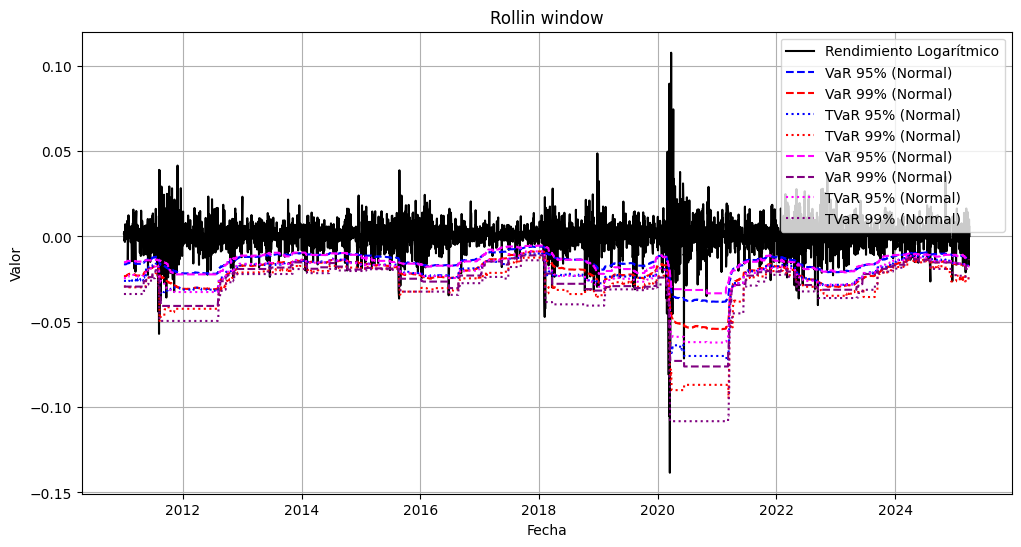

In [ ]:
r = rolling_window(rendimiento_log)

e) Violaciones

In [ ]:
def violaciones(df_resultados, rendimiento):
  n = len(df_resultados)

  #contadores
  conteo_violaciones = {
      "Violaciones_VaR_95_h": 0, "Violaciones_VaR_99_h": 0,
      "Violaciones_TVaR_95_h": 0, "Violaciones_TVaR_99_h": 0,
      "Violaciones_VaR_95_n": 0, "Violaciones_VaR_99_n": 0,
      "Violaciones_TVaR_95_n": 0, "Violaciones_TVaR_99_n": 0
  }

  for fecha in df_resultados.index:
    rendimiento_real = rendimiento.loc[fecha]

    var_h95, var_h99 = df_resultados.loc[fecha, ["VaR_95_h", "VaR_99_h"]]
    tvar_h95, tvar_h99 = df_resultados.loc[fecha, ["TVaR_95_h", "TVaR_99_h"]]
    var_n95, var_n99 = df_resultados.loc[fecha, ["VaR_95_n", "VaR_99_n"]]
    tvar_n95, tvar_n99 = df_resultados.loc[fecha, ["TVaR_95_n", "TVaR_99_n"]]

    #Sumar violaciones
    conteo_violaciones["Violaciones_VaR_95_h"] += 1 if rendimiento_real.item() < var_h95 else 0
    conteo_violaciones["Violaciones_VaR_99_h"] += 1 if rendimiento_real.item() < var_h99 else 0
    conteo_violaciones["Violaciones_TVaR_95_h"] += 1 if rendimiento_real.item() < tvar_h95 else 0
    conteo_violaciones["Violaciones_TVaR_99_h"] += 1 if rendimiento_real.item() < tvar_h99 else 0
    conteo_violaciones["Violaciones_VaR_95_n"] += 1 if rendimiento_real.item() < var_n95 else 0
    conteo_violaciones["Violaciones_VaR_99_n"] += 1 if rendimiento_real.item() < var_n99 else 0
    conteo_violaciones["Violaciones_TVaR_95_n"] += 1 if rendimiento_real.item() < tvar_n95 else 0
    conteo_violaciones["Violaciones_TVaR_99_n"] += 1 if rendimiento_real.item() < tvar_n99 else 0

  #porcentaje
  porcentaje_violaciones = {k: (v / n) * 100 for k, v in conteo_violaciones.items()} #k violaciones por caso, v la suma

  # Crear DataFrame
  df_porcentaje_violaciones = pd.DataFrame([porcentaje_violaciones])

  return df_porcentaje_violaciones

In [ ]:
violaciones(r, rendimiento_log)

,Violaciones_VaR_95_h,Violaciones_VaR_99_h,Violaciones_TVaR_95_h,Violaciones_TVaR_99_h,Violaciones_VaR_95_n,Violaciones_VaR_99_n,Violaciones_TVaR_95_n,Violaciones_TVaR_99_n
0,5.442367,1.535027,2.372314,0.921016,5.609824,2.6235,2.567681,1.200112


f)

In [ ]:
def var_volatilidad_movil(rendimiento, window=252):
    alfas = [0.95, 0.99]
    resultados = {
        "Fecha": [],
        "VaR_95_m": [],
        "VaR_99_m": []
    }

    for t in range(window, len(rendimiento)):
        datos_window = rendimiento.iloc[t-window:t].dropna()
        if len(datos_window) < window:
            raise ValueError(f"No hay suficientes datos. Se requieren mínimo {window}, pero solo hay {len(datos_window)}.")

        desviacion = datos_window.std()
        fecha_actual = rendimiento.index[t]

        # Cálculo de VaR con volatilidad móvil y distribución normal
        var_m95 = norm.ppf(1 - 0.95) * desviacion
        var_m99 = norm.ppf(1 - 0.99) * desviacion

        resultados["Fecha"].append(fecha_actual)
        resultados["VaR_95_m"].append(var_m95)
        resultados["VaR_99_m"].append(var_m99)

    df_resultados = pd.DataFrame(resultados).set_index("Fecha")


    plt.figure(figsize=(12, 6))
    plt.plot(df_resultados.index, rendimiento.loc[df_resultados.index], label="Rendimientos", color="black", alpha=0.6)
    plt.plot(df_resultados.index, df_resultados["VaR_95_m"], label="VaR 95%", linestyle="--", color="cyan")
    plt.plot(df_resultados.index, df_resultados["VaR_99_m"], label="VaR 99%", linestyle="--", color="red")
    plt.legend()
    plt.title("Volatilidad Móvil - Rolling Window 252 días")
    plt.xlabel("Fecha")
    plt.ylabel("Valor")
    plt.show()

    return df_resultados




def violaciones_var_movil(df_resultados, rendimiento):
    n = len(df_resultados)
    conteo_violaciones = {
        "Violaciones_VaR_95_m": 0,
        "Violaciones_VaR_99_m": 0
    }

    for fecha in df_resultados.index:
        rendimiento_real = rendimiento.loc[fecha].squeeze()
        rendimiento_real = rendimiento_real.item() if isinstance(rendimiento_real, (np.ndarray, pd.Series)) else rendimiento_real

        var_m95, var_m99 = df_resultados.loc[fecha, ["VaR_95_m", "VaR_99_m"]].values
        var_m95 = var_m95.item() if isinstance(var_m95, (np.ndarray, pd.Series)) else var_m95
        var_m99 = var_m99.item() if isinstance(var_m99, (np.ndarray, pd.Series)) else var_m99

        conteo_violaciones["Violaciones_VaR_95_m"] += 1 if rendimiento_real < var_m95 else 0
        conteo_violaciones["Violaciones_VaR_99_m"] += 1 if rendimiento_real < var_m99 else 0

    porcentaje_violaciones = {k: (v / n) * 100 for k, v in conteo_violaciones.items()}

    return pd.DataFrame([porcentaje_violaciones])



In [ ]:
vol = var_volatilidad_movil(rendimiento_log)
vio = violaciones_var_movil(vol, rendimiento_log)

/usr/local/lib/python3.11/dist-packages/matplotlib/cbook.py:1709: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return math.isfinite(val)
/usr/local/lib/python3.11/dist-packages/matplotlib/cbook.py:1345: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return np.asarray(x, float)


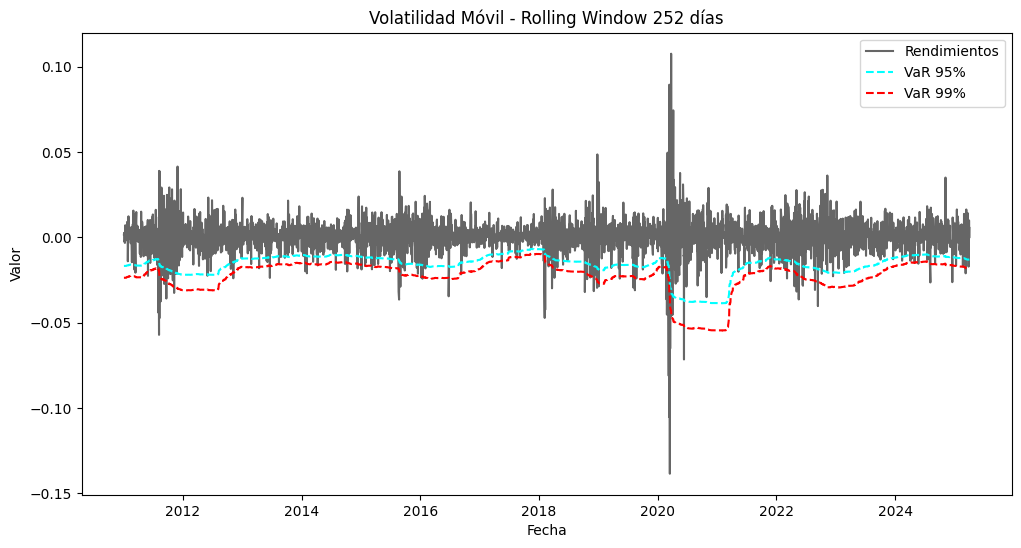

,VaR_95_m,VaR_99_m
Fecha,,
2011-01-04,Ticker ^DJI -0.0167 dtype: float64,Ticker ^DJI -0.023619 dtype: float64
2011-01-05,Ticker ^DJI -0.0167 dtype: float64,Ticker ^DJI -0.023619 dtype: float64
2011-01-06,Ticker ^DJI -0.016702 dtype: float64,Ticker ^DJI -0.023622 dtype: float64
2011-01-07,Ticker ^DJI -0.016701 dtype: float64,Ticker ^DJI -0.023621 dtype: float64
2011-01-10,Ticker ^DJI -0.016703 dtype: float64,Ticker ^DJI -0.023623 dtype: float64
...,...,...
2025-03-27,Ticker ^DJI -0.012932 dtype: float64,Ticker ^DJI -0.01829 dtype: float64
2025-03-28,Ticker ^DJI -0.012931 dtype: float64,Ticker ^DJI -0.018288 dtype: float64
2025-03-31,Ticker ^DJI -0.013055 dtype: float64,Ticker ^DJI -0.018464 dtype: float64


In [ ]:
var_volatilidad_movil(rendimiento_log)